# Analyzing IICW3C logs
python environment, functions, and examples
<br>
Sam Gartrell | 6/30/23
<br>

## environment
- Use conda to clone the environment stored in `environment.yml`
    ```
    conda env create -f environment.yml
    conda activate parse-iis
    ```

- if using this notebook, set the kernel to 'parse-iis'

- you will also need a .env file with credentials for the `geoip2` geocoder. You can set up a free account [here](maxmind.com/en/geoip2-databases)

In [12]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import requests as r
import pprint
import time
import geoip2
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
from scipy.stats import norm
import statistics

if load_dotenv():
    print('env variables loaded')

env variables loaded


## functions
Use these functions to access and analyze data stored in local log files. Recommend first developing analysis on a single log, then expanding it to target the month or set of months.

In [2]:
def log_to_df(
        log_path:str,
        fields:list=['date', 'time', 's-ip', 'cs-method', 'cs-uri-stem', 'cs-uri-query', 's-port', 'cs-username', 'c-ip', 'cs(User-Agent)', 'cs(Referer)', 'sc-status', 'sc-substatus', 'sc-win32-status', 'sc-bytes', 'time-taken']
        ):
    """
    loads a log file into a pandas dataframe
    """
    # Read the log file into a DataFrame
    df = pd.read_csv(log_path, sep=' ', header=None, names=fields, skiprows=4)

    # add a unique ID to dataframe so it can be cut into subsets
    df['uid'] = range(1, len(df) + 1)

    return df

def logs_to_df(
        folder_path:str,
        fields:list=['date', 'time', 's-ip', 'cs-method', 'cs-uri-stem', 'cs-uri-query', 's-port', 'cs-username', 'c-ip', 'cs(User-Agent)', 'cs(Referer)', 'sc-status', 'sc-substatus', 'sc-win32-status', 'sc-bytes', 'time-taken']
        ):
    """
    loads a folder of log files into a single pandas dataframe. all log files must have the same fields, and follow the ISSW3C spec.
    """
    start = time.time()

    # initialize list for per-log dataframes, later flattened
    dfs = []

    # for each log file in the target folder,
    for file in os.listdir(folder_path):
        if file.endswith('.log'):
            log = os.path.join(folder_path, file)
            
            # read it into a dataframe (ignore 1st 4 lines, in keeping with ISSW3C format)
            # add it to the list
            dfs.append(pd.read_csv(log, sep=' ', header=None, names=fields, skiprows=4))
            # print(file, "read successfully")

    # flatten the list
    folder_df = pd.concat(dfs, axis=0, ignore_index=True)

    # add a unique ID to dataframe so it can be cut into subsets
    folder_df['uid'] = range(1, len(folder_df) + 1)


    print(f'took {time.time() - start} sec')
    return folder_df

def ip_request_statistics(dataframe:pd.DataFrame, use_log=True):
    """
    computes mean, standard deviation of request counts by IP,
    and gives z-score of most prolific IP (log2-transformed if use_log)
    """
    # Calculate the request count per IP address (log-transformed)
    request_counts = dataframe['c-ip'].value_counts()
    if use_log:
        request_counts = np.log2(
            request_counts
        )
        

    # Calculate the mean and standard deviation of request counts
    mean_requests = request_counts.mean()
    std_requests = request_counts.std()

    # Identify the most prolific IP address
    most_prolific_ip = request_counts.idxmax()

    # Calculate the z-score for the most prolific IP address
    z_score = (request_counts[most_prolific_ip] - mean_requests) / std_requests

    return {
        'mean_request_count': mean_requests,
        'stdev_request_count': std_requests,
        'top_10': list(dataframe['c-ip'].value_counts().head(10).index),
        'n_unique': dataframe['c-ip'].nunique(),
        'top': {
            'address': most_prolific_ip,
            'request_count': request_counts.max(),
            'z_score': z_score
        },
        'used_log': use_log
    }

### Example: view and visualize request statistics by IP in a log file

In [6]:
# load log file for a given day
oct4 = log_to_df(r'd:/metro/logs/202210/u_ex221004.log')

# get and view ip stats
stats = ip_request_statistics(oct4)
print(
    pprint.pformat(stats)
)

{'mean_request_count': 3.493246446838115,
 'n_unique': 3803,
 'stdev_request_count': 2.563869950055838,
 'top': {'address': '52.205.137.89',
         'request_count': 14.928287036957299,
         'z_score': 4.460070445410127},
 'top_10': ['52.205.137.89',
            '34.234.176.30',
            '34.233.233.138',
            '208.71.202.129',
            '204.147.152.14',
            '204.147.152.5',
            '10.80.101.81',
            '67.160.140.19',
            '10.80.101.208',
            '205.173.217.10'],
 'used_log': True}


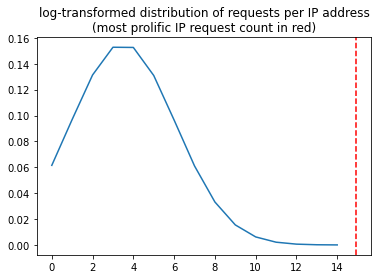

In [7]:
# look at log-transformed request counts per IP stats
x_axis = np.arange(
    0,
    stats['top']['request_count']
)

plt.plot(
    x_axis,
    norm.pdf(x_axis, stats['mean_request_count'],
             stats['stdev_request_count'])
)

plt.title('log-transformed distribution of requests per IP address\n(most prolific IP request count in red)')

# add most prolific IP
plt.axvline(x=stats['top']['request_count'], color='r', linestyle='--')

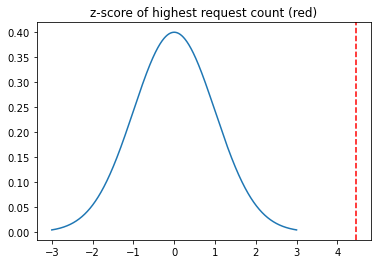

In [9]:
# standardize distribution to look at z-score
x_axis = np.arange(-3, 3, 0.001)
plt.plot(x_axis, norm.pdf(x_axis, 0, 1))
plt.title('z-score of highest request count (red)')

# adding z-score
plt.axvline(x=stats['top']['z_score'], color='r', linestyle='--')

In [ ]:
# find the proportion of stems relevant to metromap (actual usages)
mm_stem = df[df['cs-uri-stem'].str.contains('metromap')]
mm_stem_proportion = len(mm_stem) / len(df)
print(mm_stem_proportion)

# identify requests referred FROM metromap
mm_rfrr = df[df['cs(Referer)'].str.contains('metromap')]
mm_rfrr_proportion = len(mm_rfrr) / len(df)
print(mm_rfrr_proportion)

# identify unsecured ('http://') metromap usages
mm_rfrr_unsec = mm_rfrr

In [ ]:
# find ip metrics for a log dataframe
def get_ip_metrics(dataframe:pd.DataFrame):
    return {
    'most_common': dataframe['c-ip'].mode()[0],
    'top_10': list(dataframe['c-ip'].value_counts().head(10).index),
    'n_unique': dataframe['c-ip'].nunique()
}

get_ip_metrics(mm_stem)
get_ip_metrics(mm_rfrr)

In [14]:
def geocode_ip(dataframe: pd.DataFrame, sample_size: int = 100):
    """
    returns a geodataframe of points representing IP addresses from the dataframe passed.
    Works well with a df that's already grouped by IP address, to maximize the number of unique IPs sampled and geocoded.
    only 1000 requests/day are permitted; consider upgrading to a paid svc 
    """
    # geocoder api stuff
    key = os.getenv('GEOIP2_KEY') # api key
    aid = os.getenv('GEOIP2_AID') # acc id

    # get every nth record to reduce burden on geocoder
    subset = dataframe.sample(n=sample_size)
    subset['lat'] = ""
    subset['lon'] = ""
    subset['reserved_ip'] = False

    # for each row, geocode its ip
    with geoip2.webservice.Client(aid, key, host='geolite.info') as client:
        for row_index, row in subset.iterrows():
            try:
                response = client.city(row['c-ip'])
                lon = response.location.longitude
                lat = response.location.latitude
                subset.loc[row_index, ['lon', 'lat']] = [lon, lat]
            except geoip2.errors.AddressNotFoundError:
                subset.loc[row_index, 'reserved_ip'] = True

    spatial_subset = subset[subset['reserved_ip'] == False]
    geometry = [Point(lon, lat)]

oct4_geocoded = geocode_ip(oct4, sample_size=10)

In [15]:
oct4_geocoded

,date,time,s-ip,cs-method,cs-uri-stem,cs-uri-query,s-port,cs-username,c-ip,cs(User-Agent),cs(Referer),sc-status,sc-substatus,sc-win32-status,sc-bytes,time-taken,uid,lat,lon,reserved_ip
175452,2022-10-04,18:18:48,10.50.40.56,GET,/arcgis/rest/services/photo/2019aerialphoto/Ma...,token=fkjHdWdk34bywEL-hLblhArmTEuVbuOuGd3Y77S9...,443,-,204.147.152.5,Mozilla/5.0+(Windows+NT+10.0;+Win64;+x64)+Appl...,http://pwebnut1.co.washington.or.us/,200,0,0,44047,78,175453,45.5397,-122.9638,False
32015,2022-10-04,14:58:30,10.50.40.56,GET,/arcgis/services/photo/aerialphoto/MapServer/W...,version=1.3.0&request=GetMap&CRS=EPSG:3857&bbo...,443,-,136.226.56.83,Mozilla/5.0+(Windows+NT+10.0;+Win64;+x64)+Appl...,https://www.portgis.com/,200,0,0,69689,78,32016,45.5288,-122.6821,False
56631,2022-10-04,15:57:00,10.50.40.56,GET,/services/Land/ORCA_ParksAndNaturalAreas/12/64...,token=PrcoZcKFUAcgtA4j8AQCLETBx_u4g0vXoIbBjEzf...,443,-,10.80.101.208,Mozilla/5.0+(Windows+NT+10.0;+Win64;+x64)+Appl...,https://gis.oregonmetro.gov/,200,0,0,1397,46,56632,,,True
58125,2022-10-04,15:57:37,10.50.40.56,GET,/ArcGIS/rest/services/metromap/baseAnno/MapSer...,token=7eXr3OCSVOChwnKR1_--HMhwvvtw9hRn9ymyFYCT...,443,-,38.126.64.89,Mozilla/5.0+(Windows+NT+10.0;+Win64;+x64)+Appl...,https://gis.oregonmetro.gov/,304,0,0,309,250,58126,45.2897,-122.3219,False
172485,2022-10-04,18:15:42,10.50.40.56,GET,/ArcGIS/rest/services/metromap/baseActive/MapS...,token=GYJZSQrfbb8YrZ_RIn-64Kc1SpybpK4LpW4TenvG...,443,-,50.231.157.58,Mozilla/5.0+(Windows+NT+10.0;+Win64;+x64)+Appl...,https://gis.oregonmetro.gov/,200,0,0,8229,15,172486,45.5176,-122.6721,False
31939,2022-10-04,14:58:28,10.50.40.56,GET,/arcgis/services/photo/aerialphoto/MapServer/W...,version=1.3.0&request=GetMap&CRS=EPSG:3857&bbo...,443,-,136.226.56.83,Mozilla/5.0+(Windows+NT+10.0;+Win64;+x64)+Appl...,https://www.portgis.com/,200,0,0,94510,328,31940,45.5288,-122.6821,False
40987,2022-10-04,15:26:16,10.50.40.56,GET,/arcgis/rest/services/metromap/baseAnno/MapSer...,token=fkjHdWdk34bywEL-hLblhArmTEuVbuOuGd3Y77S9...,443,-,204.147.152.5,Mozilla/5.0+(Windows+NT+10.0;+Win64;+x64)+Appl...,http://pwebnut1.co.washington.or.us/,200,0,0,2389,78,40988,45.5397,-122.9638,False
87149,2022-10-04,16:38:57,10.50.40.56,POST,/arcgis/tokens/generateToken,-,443,-,34.234.176.30,Apache-HttpClient/4.5.13+(Java/11.0.16.1),http://www.arcgis.com,200,0,0,517,140,87150,39.0469,-77.4903,False
31169,2022-10-04,14:55:37,10.50.40.56,GET,/arcgis/rest/services/taxlots/MapServer/export,dpi=96&transparent=true&format=png32&layers=sh...,443,-,34.221.27.87,-,https://apps.intterragroup.com/,200,0,0,71561,249,31170,45.8234,-119.7257,False
58250,2022-10-04,15:57:38,10.50.40.56,GET,/ArcGIS/rest/services/metromap/baseSimple/MapS...,token=jtJ3qevgR0oEBOZQVIrdF9nCWVlzEOnMqNi62ask...,443,-,198.245.132.3,Mozilla/5.0+(Windows+NT+10.0;+Win64;+x64)+Appl...,https://gis.oregonmetro.gov/,304,0,0,309,250,58251,45.3378,-122.5724,False


In [ ]:
# look at User Agent info. Assumes that ios, Mozilla